In [56]:
# Importaciones requeridas
import numpy as np
import matplotlib.pyplot as plt
import copy

### Definición de la clase "Elemento" que representa un elemento finito tipo viga

In [57]:
class Elemento:
    """
    Clase que representa un elemento tipo Viga. Para efectos de cálculo, cada elemento de
    la clase "Elemento" es un elemento finito tipo "Viga". Esta clase contiene las matrices
    de rigidez de los siguientes modelos matemáticos: Euler-Bernoulli, cortante inducido
    por la carga axial, cortante inducido por cargas transversales y, finalmente, cortante
    combinado.
    """
    
    def __init__(self, *, longitud, area, inercia, E, G, n, axial, carga_distribuida):
        self.l = longitud
        self.A = area
        self.I = inercia
        self.E = E
        self.G = G
        self.n = n
        self.P = axial
        self.q = carga_distribuida
        self.r = self.E*self.I/(self.n*self.A*self.G)
        self.beta = 1 + self.P/(self.n*self.A*self.G)
        k_axial = self.A/(self.l*self.I)

        # CONSTRUCCIÓN DE LA MATRIZ CLÁSICA (MODELO EULER-BERNOULLI) ***********
        self.matriz_clasica = (self.E*self.I)*np.array([

            [    k_axial,         0,                0,         -k_axial,            0,                0         ],
            [       0,       12/self.l**3,     6/self.l**2,        0,        -12/self.l**3,      6/self.l**2    ],
            [       0,       6/self.l**2,      4/self.l,           0,        -6/self.l**2,       2/self.l       ],
            [   -k_axial,         0,                0,          k_axial,            0,                0,        ],
            [       0,      -12/self.l**3,    -6/self.l**2,        0,         12/self.l**3,     -6/self.l**2    ],
            [       0,       6/self.l**2,      2/self.l,           0,        -6/self.l**2,       4/self.l       ]

        ])

        # CONSTRUCCIÓN DE LA MATRIZ CON CORTANTE POR CARGA AXIAL ***************
        self.matriz_corte_axial = self.beta*self.matriz_clasica
        self.matriz_corte_axial[0] = self.matriz_corte_axial[0]/self.beta
        self.matriz_corte_axial[3] = self.matriz_corte_axial[3]/self.beta

        # CONSTRUCCIÓN DE LA MATRIZ CON CORTANTE DIRECTO ***********************
        # Factores de modificación (por cortante directo) de la matriz clásica
        self.F = {
            'F1': (self.l**2)/(self.l**2 + 6*self.r),
            'F2': (self.l**2 + 2*self.r)/(self.l**2 + 6*self.r),
            'F3': (self.l**2 + 3*self.r)/(self.l**2 + 6*self.r),
            'F4': (self.l**2 - 2*self.r)/(self.l**2 + 6*self.r),
            'F5': (self.l**2 - 6*self.r)/(self.l**2 + 6*self.r)
        }
        
        self.matriz_transformacion_corte_directo = np.array([

            [    1,         0,              0,            1,          0,              0          ],
            [    0,     self.F['F1'],   self.F['F1'],     0,      self.F['F1'],   self.F['F1']   ],
            [    0,     self.F['F2'],   self.F['F3'],     0,      self.F['F4'],   self.F['F5']   ],
            [    1,         0,              0,            1,          0,              0          ],
            [    0,     self.F['F1'],   self.F['F1'],     0,      self.F['F1'],   self.F['F1']   ],
            [    0,     self.F['F4'],   self.F['F5'],     0,      self.F['F2'],   self.F['F3']   ]

        ])

        self.matriz_corte_directo = self.matriz_clasica*self.matriz_transformacion_corte_directo

        # CONSTRUCCIÓN DE LA MATRIZ DE CORTANTE TOTAL (DIRECTO + AXIAL) ********
        self.matriz_corte_total = self.beta*self.matriz_corte_directo

        # CONSTRUCCIÓN DEL ECTORE DE FUERZAS EN LOS EXTREMOS
        # Vector sin efectos del cortante
        self.Qf = np.array([
            0,
            -self.q*self.l/2,
            -(self.q*self.l**2)/12,
            0,
            -self.q*self.l/2,
            (self.q*self.l**2)/12
        ])
        
        #Vector con efectos del cortante
        f = (self.l**2 + 6*self.r)/self.l**2

        self.Qf_corte = np.array([
            0,
            -self.q*self.l/2,
            (-(self.q*self.l**2)/12)*f,
            0,
            -self.q*self.l/2,
            ((self.q*self.l**2)/12)*f
        ])

    # DEFINICIÓN DEL MÉTODO __add__() PARA ENSAMBLAR ELEMNETOS (SUMAR CLASES "ELEMENTO")
    '''
    Este método es el que permitirá más adelante ensamblar varios elementos finitos (de tipo
    "Elemento") en una sola entidad de tipo Viga para poder ejecutar un análisis de elementos
    finitos usando los diferentes modelos matemáticos de la rigidez
    '''
    def __add__(self, other):
        # Dimensiones de la primera matriz
        dim = self.matriz_clasica.shape[0]
        dim_other = other.matriz_clasica.shape[0]

        # Inicialización en ceros de las matrices y vector resultante con sus dimensiones finales
        matriz_clasica_temporal = np.zeros(shape=(dim+3, dim+3))
        matriz_corte_directo_temporal = np.zeros(shape=(dim+3, dim+3))
        matriz_corte_axial_temporal = np.zeros(shape=(dim+3, dim+3))
        matriz_corte_total_temporal = np.zeros(shape=(dim+3, dim+3))
        vector_temporal = np.zeros(dim+3)
        vector_temporal_corte = np.zeros(dim+3)
        
        # Ensamble de la matriz clásica resultante
        matriz_clasica_temporal[0:dim, 0:dim] += self.matriz_clasica
        matriz_clasica_temporal[-dim_other:, -dim_other:] += other.matriz_clasica

        # Ensamble de la matriz de cortante directo resultante
        matriz_corte_directo_temporal[0:dim, 0:dim] += self.matriz_corte_directo
        matriz_corte_directo_temporal[-dim_other:, -dim_other:] += other.matriz_corte_directo

        # Ensamble de la matriz de cortante por axial resultante
        matriz_corte_axial_temporal[0:dim, 0:dim] += self.matriz_corte_axial
        matriz_corte_axial_temporal[-dim_other:, -dim_other:] += other.matriz_corte_axial

        # Ensamble de la matriz de cortante total resultante
        matriz_corte_total_temporal[0:dim, 0:dim] += self.matriz_corte_total
        matriz_corte_total_temporal[-dim_other:, -dim_other:] += other.matriz_corte_total

        # Ensamble del vector de carga resultante clásico (aplica a los modelos clasico y corte por axial)
        vector_temporal[0:dim] += self.Qf
        vector_temporal[-dim_other:] += other.Qf

        # Ensamble del vector de carga resultante con corte (aplica a los modelos de corte directo y corte total)
        vector_temporal_corte[0:dim] += self.Qf_corte
        vector_temporal_corte[-dim_other:] += other.Qf_corte
        
        # Creación y retorno de instancia cuyas matrices son las matrices ensambladas
        instancia_temporal = copy.deepcopy(self)
        instancia_temporal.matriz_clasica = matriz_clasica_temporal
        instancia_temporal.matriz_corte_axial = matriz_corte_axial_temporal
        instancia_temporal.matriz_corte_directo = matriz_corte_directo_temporal
        instancia_temporal.matriz_corte_total = matriz_corte_total_temporal
        instancia_temporal.Qf = vector_temporal
        instancia_temporal.Qf_corte = vector_temporal_corte

        return instancia_temporal
    
    def __str__(self):
        descripcion = f"""LAS PROPIEDADES MECÁNICAS DEL ELEMENTO SON:
        
        PROPIEDADES GEOMÉTRICAS:
        Longitud del elemento: {self.l} m
        Área de la sección transversal: {10000*self.A} cm^2
        El momento de inercia de la sección es: {self.I*100**4} cm^4
        El factor de alabeo de la sección es: {self.n}
        
        PROPIEDADES DEL MATERIAL:
        El módulo de elasticidad es: {self.E*10**-9} GPa
        El módulo de elasticidad a cortante es: {self.G*10**-9} GPa
        
        CARGAS:
        La carga axial es: {self.P/1000} kN
        La carga distribuida es: {self.q/1000} kN/m
        """        
        return descripcion
    
    def __repr__(self):
        mensaje = '''
        Clase que representa un elemento tipo Viga. Para efectos de cálculo, cada elemento de
        la clase "Elemento" es un elemento finito tipo "Viga". Esta clase contiene las matrices
        de rigidez de los siguientes modelos matemáticos: Euler-Bernoulli, cortante inducido
        por la carga axial, cortante inducido por cargas transversales y, finalmente, cortante
        combinado.
        '''
        return mensaje

In [60]:
# Ensayo de la clase "Elemento"

un_elemento = Elemento(longitud=1.5,
                       area=0.09,
                       inercia=0.000675,
                       E=200000000000,
                       G=80000000000,
                       axial=100000,
                       carga_distribuida=10000,
                       n=0.75)

In [61]:
print(un_elemento)

LAS PROPIEDADES MECÁNICAS DEL ELEMENTO SON:
        
        PROPIEDADES GEOMÉTRICAS:
        Longitud del elemento: 1.5 m
        Área de la sección transversal: 900.0 cm^2
        El momento de inercia de la sección es: 67500.0 cm^4
        El factor de alabeo de la sección es: 0.75
        
        PROPIEDADES DEL MATERIAL:
        El módulo de elasticidad es: 200.0 GPa
        El módulo de elasticidad a cortante es: 80.0 GPa
        
        CARGAS:
        La carga axial es: 100.0 kN
        La carga distribuida es: 10.0 kN/m
        


In [62]:
mi_elemento.__repr__

<bound method Elemento.__repr__ of 
        Clase que representa un elemento tipo Viga. Para efectos de cálculo, cada elemento de
        la clase "Elemento" es un elemento finito tipo "Viga". Esta clase contiene las matrices
        de rigidez de los siguientes modelos matemáticos: Euler-Bernoulli, cortante inducido
        por la carga axial, cortante inducido por cargas transversales y, finalmente, cortante
        combinado.
        >

### Definición de la clase "Viga", formada por instancias de la clase "Elemento"

In [98]:
class Viga:
    """
    Esta clase representa una viga compuesta por n elementos finitos (representados por instncias
    de la clase "Elemento"). Las propiedades mecánicas de la viga son las mismas de sus elementos
    constituyentes.
    """
    
    def __init__(
            self,
            *,
            longitud, 
            area, 
            inercia, 
            E, 
            G, 
            n, 
            axial,
            carga_distribuida,
            num_elementos, # En realidad, esta variable representa el número de nodos!!
    ):
        self.l_c = longitud
        self.A = area
        self.I = inercia
        self.E = E
        self.G = G
        self.n = n
        self.P = axial
        self.q = carga_distribuida
        self.num_elementos = int(num_elementos)

        if self.num_elementos % 2 != 0:
            self.num_elementos += 1
        
        self.longitud_elemento = self.l_c/self.num_elementos
        
        # Argumentos para inicializar los elementos finitos (instancias de la clase "Elemento")
        kwargs = {
            'longitud': self.longitud_elemento,
            'area':     self.A,
            'inercia':  self.I,
            'E':        self.E,
            'G':        self.G,
            'n':        self.n,
            'axial':    self.P,
            'carga_distribuida': self.q
        }
        
        # Proceso de ensamble de los elementos (ensamble de las matrices de rigidez)
        self.elementos = [Elemento(**kwargs) for i in range(self.num_elementos)]

        C = self.elementos[0]
        for elemento in self.elementos[1:]:
            C += elemento
        
        # Asignación de las matrices ensambladas: matrices de rigidez globales de la viga
        self.matriz_clasica = C.matriz_clasica
        self.matriz_corte_axial = C.matriz_corte_axial
        self.matriz_corte_directo = C.matriz_corte_directo
        self.matriz_corte_total = C.matriz_corte_total
        self.Qf = C.Qf
        self.Qf_corte = C.Qf_corte
    
    # Método que ejecuta la reducción de las matrices de acuerdo a las condiciones de frontera
    def reducir_matrices(self, matriz, vector, apoyo_1, apoyo_2):
        matriz_temporal = copy.deepcopy(matriz)
        vector_temporal = copy.deepcopy(vector)

        if apoyo_1['x'] == 0:
            matriz_temporal = np.delete(matriz_temporal, 0, axis=0)
            matriz_temporal = np.delete(matriz_temporal, 0, axis=1)
            vector_temporal = np.delete(vector_temporal, 0)
            if apoyo_1['y'] == 0:
                matriz_temporal = np.delete(matriz_temporal, 0, axis=0)
                matriz_temporal = np.delete(matriz_temporal, 0, axis=1)
                vector_temporal = np.delete(vector_temporal, 0)
                if apoyo_1['r'] == 0:
                    matriz_temporal = np.delete(matriz_temporal, 0, axis=0)
                    matriz_temporal = np.delete(matriz_temporal, 0, axis=1)
                    vector_temporal = np.delete(vector_temporal, 0)
            elif apoyo_1['r'] == 0:
                matriz_temporal = np.delete(matriz_temporal, 1, axis=0)
                matriz_temporal = np.delete(matriz_temporal, 1, axis=1)
                vector_temporal = np.delete(vector_temporal, 1)
        elif apoyo_1['y'] == 0:
            matriz_temporal = np.delete(matriz_temporal, 1, axis=0)
            matriz_temporal = np.delete(matriz_temporal, 1, axis=1)
            vector_temporal = np.delete(vector_temporal, 1)
            if apoyo_1['r'] == 0:
                matriz_temporal = np.delete(matriz_temporal, 1, axis=0)
                matriz_temporal = np.delete(matriz_temporal, 1, axis=1)
                vector_temporal = np.delete(vector_temporal, 1)
        elif apoyo_1['r'] == 0:
            matriz_temporal = np.delete(matriz_temporal, 2, axis=0)
            matriz_temporal = np.delete(matriz_temporal, 2, axis=1)
            vector_temporal = np.delete(vector_temporal, 2)
        

        if apoyo_2['x'] == 0:
            matriz_temporal = np.delete(matriz_temporal, -1, axis=0)
            matriz_temporal = np.delete(matriz_temporal, -1, axis=1)
            vector_temporal = np.delete(vector_temporal, -1)
            if apoyo_2['y'] == 0:
                matriz_temporal = np.delete(matriz_temporal, -1, axis=0)
                matriz_temporal = np.delete(matriz_temporal, -1, axis=1)
                vector_temporal = np.delete(vector_temporal, -1)
                if apoyo_2['r'] == 0:
                    matriz_temporal = np.delete(matriz_temporal, -1, axis=0)
                    matriz_temporal = np.delete(matriz_temporal, -1, axis=1)
                    vector_temporal = np.delete(vector_temporal, -1)
            elif apoyo_2['r'] == 0:
                matriz_temporal = np.delete(matriz_temporal, -2, axis=0)
                matriz_temporal = np.delete(matriz_temporal, -2, axis=1)
                vector_temporal = np.delete(vector_temporal, -2)
        elif apoyo_2['y'] == 0:
            matriz_temporal = np.delete(matriz_temporal, -2, axis=0)
            matriz_temporal = np.delete(matriz_temporal, -2, axis=1)
            vector_temporal = np.delete(vector_temporal, -2)
            if apoyo_2['r'] == 0:
                matriz_temporal = np.delete(matriz_temporal, -2, axis=0)
                matriz_temporal = np.delete(matriz_temporal, -2, axis=1)
                vector_temporal = np.delete(vector_temporal, -2)
        elif apoyo_2['r'] == 0:
            matriz_temporal = np.delete(matriz_temporal, -3, axis=0)
            matriz_temporal = np.delete(matriz_temporal, -3, axis=1)
            vector_temporal = np.delete(vector_temporal, -3)
        
        reducidos = {
            'matriz': matriz_temporal,
            'vector': vector_temporal
        }
        
        return reducidos
    
    # Método que calcula las deflexiones debido a la carga distribuída y carga axial
    def deflexion_distribuida(self, apoyo_1, apoyo_2):
        deflexiones = {'x': np.arange(0, self.l_c + self.longitud_elemento, self.longitud_elemento)}

        modelos = {
            'clasico':       self.reducir_matrices(self.matriz_clasica, self.Qf_corte, apoyo_1, apoyo_2),
            'corte_axial':   self.reducir_matrices(self.matriz_corte_axial, self.Qf_corte, apoyo_1, apoyo_2),
            'corte_directo': self.reducir_matrices(self.matriz_corte_directo, self.Qf_corte, apoyo_1, apoyo_2),
            'corte_total':   self.reducir_matrices(self.matriz_corte_total, self.Qf_corte, apoyo_1, apoyo_2)
        }

        for key in modelos:
            y = np.linalg.inv(modelos[key]['matriz']).dot(-modelos[key]['vector'])
            deflexiones[key] = y[1::3]
            
            if apoyo_1['y'] == 0:
                deflexiones[key] = np.insert(deflexiones[key], 0, 0)
            if apoyo_2['y'] == 0:
                deflexiones[key] = np.append(deflexiones[key], 0)
        
        return deflexiones

### Ensayos generales de las clases definidas arriba

In [108]:
# Instanciación de un elemento viga y condiciones de apoyo

mi_viga = Viga(longitud=6,
               area=0.00538,
               inercia=0.0000836,
               E=200000000000,
               G=70000000000,
               n=0.66,
               axial=-50000000,
               carga_distribuida=1000,
               num_elementos=50)

apoyo1, apoyo2 = {'x': 0, 'y':0, 'r':0}, {'x': 1, 'y':1, 'r':1}

In [115]:
# Deflexiones de la viga
deflexion = mi_viga.deflexion_distribuida(apoyo1, apoyo2)

In [116]:
# Modelos calculados
deflexion.keys()

dict_keys(['x', 'clasico', 'corte_axial', 'corte_directo', 'corte_total'])

In [118]:
for key in deflexion.keys():
    print(f'El tamaño del vector {key} es {len(deflexion[key])}')

El tamaño del vector x es 51
El tamaño del vector clasico es 51
El tamaño del vector corte_axial es 51
El tamaño del vector corte_directo es 51
El tamaño del vector corte_total es 51


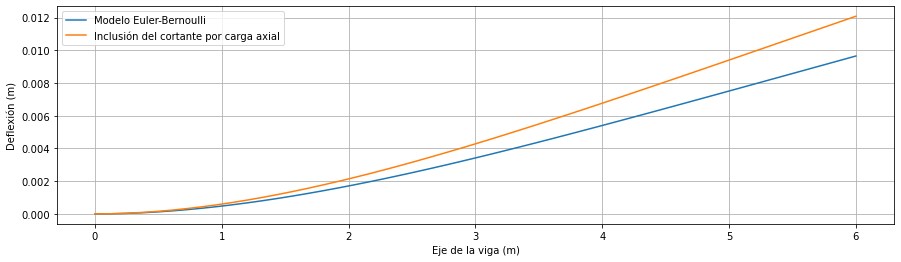

In [130]:
# Grafica de las deflexiones
plt.figure(figsize=(15, 4))
plt.plot(deflexion['x'], deflexion['clasico'], label='Modelo Euler-Bernoulli')
plt.plot(deflexion['x'], deflexion['corte_axial'], label='Inclusión del cortante por carga axial')
plt.xlabel('Eje de la viga (m)')
plt.ylabel('Deflexión (m)')
plt.grid()
plt.legend();

In [137]:
# Diferencia entre las deflexiones
f = deflexion['corte_axial'][1:]/deflexion['clasico'][1:]
print(f, '\n')
print(f'El valor de beta es {1/mi_viga.elementos[0].beta}')

[1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813 1.25181813
 1.25181813 1.25181813] 

El valor de beta es 1.251818126876045
